# Проект_e-commerce

#### В.С. Бирин, А. О. Шабалин

In [345]:
import datetime
import calendar
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import f_oneway, ttest_ind, chi2_contingency

Загружаем датасет

In [346]:
df = pd.read_csv('data.csv', delimiter=',')

Переименовываем столбцы в формате PEP8

In [347]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df = df.rename(columns={"sessiondurationsec": "session_duration_sec"})

Переводим столбцы в тип datetime

In [348]:
col_names = ["session_start", "session_end",
             "session_date", "order_dt"]
df[col_names] = df[col_names].apply(pd.to_datetime)

Удаляем строки с пропущенными важными значениями (без этих значений строки бесполезны). Объяснение появления таких пропусков - пользователь перезашел на сайт.

In [349]:
col_names = ["user_id", "region",
             "device", "channel",
             "session_start", "session_end",
             "session_date", "month",
             "day", "hour_of_day"]  # обязательные столбцы
df = df.drop(df[df[col_names].isnull().any(axis=1)].index.tolist())
len(df)

999

Удаляем дубликаты (как раз те строки, которые появились из-за пользователей, перезашедших на сайт.

In [350]:
df = df.drop(df[df.duplicated(["user_id", "session_start"])].index.tolist())
len(df)

997

In [351]:
len(df["user_id"].unique()), df["user_id"].count()  # все пользователи уникальные

(997, 997)

Проверим корректность данных внутри столбцов *session_start*, *session_end*, *session_date*, *session_duration_sec*

In [352]:
df["session_start"].apply(lambda x: 2019 <= x.to_pydatetime().year < 2020).all()  # все session_start в 2019 году

True

In [353]:
df["session_end"].apply(lambda x: x.year == 2019 <= x.to_pydatetime().year < 2020).all()  # все session_end в 2019 году

True

In [354]:
df.apply(lambda x: x["session_start"].date() == x["session_date"].date(),
         axis=1).all()  # все session_start совпадают с session_date

True

In [355]:
df.apply(lambda x:
         (x["session_end"] - x["session_start"] - pd.Timedelta(
             seconds=x["session_duration_sec"])).nanoseconds < 1000,
         axis=1).all()  # все session_start + duration < session_end


True

Форматируем столбец *promo_code*

In [356]:
df[["user_id", "promo_code"]]

,user_id,promo_code
0,529697267522,0.0
1,601292388085,NaN
2,852898876338,NaN
3,998513020664,NaN
4,240702200943,NaN
...,...,...
1007,246163171672,NaN
1008,660140862425,NaN
1009,898253063062,NaN
1010,780224321316,NaN


In [357]:
df["promo_code"] = df.apply(lambda x: 0 if x["promo_code"] is None or x["promo_code"] == 0 else 1, axis=1)
df[["user_id", "promo_code"]]

,user_id,promo_code
0,529697267522,0
1,601292388085,1
2,852898876338,1
3,998513020664,1
4,240702200943,1
...,...,...
1007,246163171672,1
1008,660140862425,1
1009,898253063062,1
1010,780224321316,1


Создаём столбец *total_price* на основе *revenue* и *promo_code*

In [358]:
df["total_price"] = df.apply(lambda x: x["revenue"] * 0.9 if x["promo_code"] == 1 else x["revenue"], axis=1).fillna(0)
df[["user_id", "total_price"]]

,user_id,total_price
0,529697267522,9999.0
1,601292388085,0.0
2,852898876338,0.0
3,998513020664,0.0
4,240702200943,0.0
...,...,...
1007,246163171672,0.0
1008,660140862425,0.0
1009,898253063062,0.0
1010,780224321316,0.0


Смотрим на *total_price*

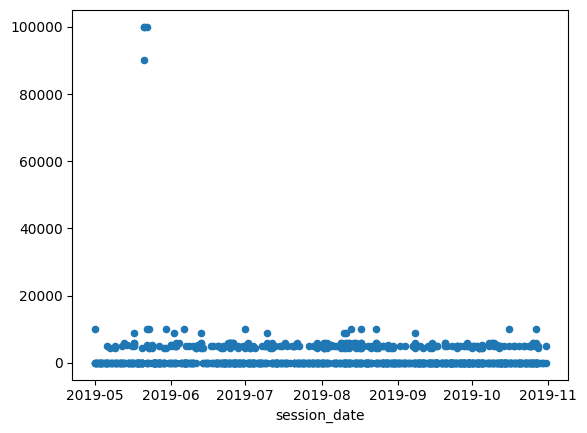

In [359]:
sc = df[["session_date", "total_price"]]
sc.plot.scatter(x="session_date", y="total_price")
plt.ylabel("")
plt.show()

Изходя из точечной диаграммы делаем вывод, что значения 1, 90'000 и 100'000 - выброс. Избавляемся от них. 

In [360]:
df = df[((df["total_price"] > 1) | (df["total_price"] == 0)) & (df["total_price"] < 90000)]
df[["user_id", "total_price"]]

,user_id,total_price
0,529697267522,9999.0
1,601292388085,0.0
2,852898876338,0.0
3,998513020664,0.0
4,240702200943,0.0
...,...,...
1007,246163171672,0.0
1008,660140862425,0.0
1009,898253063062,0.0
1010,780224321316,0.0


Заменяем опечатки в данных столбца *region*

In [361]:
df["region"] = (df["region"]
                .replace("United States", "United States")
                .replace("Frаnce", "France")
                .replace("Unjted States", "United States")
                .replace("Germany", "Germany")
                .replace("UK", "UK")
                .replace("France", "France")
                .replace("Frаncе", "France")
                .replace("Franсe", "France")
                .replace("germany", "Germany")
                .replace("UК", "UK"))

Заменяем опечатки в столбце *device*

In [362]:
df["device"] = df["device"].replace("android", "Android")

Заменяем опечатки в столбце *channel*

In [363]:
df["channel"] = df["channel"].replace("контексная реклама", "контекстная реклама")

Создаём новый столбец *visit_time* - время суток

In [364]:
def get_visit_time(x):
    if datetime.time(hour=6) <= x["session_start"].time() < datetime.time(hour=10):
        return "morning"
    if datetime.time(hour=10) <= x["session_start"].time() < datetime.time(hour=17):
        return "afternoon"
    if datetime.time(hour=17) <= x["session_start"].time() < datetime.time(hour=22):
        return "evening"
    if datetime.time(hour=0) <= x["session_start"].time() < datetime.time(hour=6) or datetime.time(hour=22) <= x[
        "session_start"].time():
        return "night"


df["visit_time"] = df.apply(get_visit_time, axis=1)
df[["user_id", "visit_time"]]

,user_id,visit_time
0,529697267522,night
1,601292388085,morning
2,852898876338,night
3,998513020664,evening
4,240702200943,afternoon
...,...,...
1007,246163171672,evening
1008,660140862425,evening
1009,898253063062,night
1010,780224321316,night


Создаём столбец *payer* - плательщик или нет

In [365]:
df["payer"] = df["total_price"].map(lambda x: 1 if x > 0 else 0)
df[["user_id", "total_price", "payer"]]

,user_id,total_price,payer
0,529697267522,9999.0,1
1,601292388085,0.0,0
2,852898876338,0.0,0
3,998513020664,0.0,0
4,240702200943,0.0,0
...,...,...,...
1007,246163171672,0.0,0
1008,660140862425,0.0,0
1009,898253063062,0.0,0
1010,780224321316,0.0,0


In [366]:
df["s_month"] = df['session_date'].dt.strftime('%b')
df[["session_date", "s_month"]]

,session_date,s_month
0,2019-05-01,May
1,2019-05-01,May
2,2019-05-01,May
3,2019-05-01,May
4,2019-05-02,May
...,...,...
1007,2019-10-29,Oct
1008,2019-10-30,Oct
1009,2019-10-30,Oct
1010,2019-10-31,Oct


In [367]:
df["s_day"] = df['session_date'].dt.strftime('%a')
df[["session_date", "s_day"]]


,session_date,s_day
0,2019-05-01,Wed
1,2019-05-01,Wed
2,2019-05-01,Wed
3,2019-05-01,Wed
4,2019-05-02,Thu
...,...,...
1007,2019-10-29,Tue
1008,2019-10-30,Wed
1009,2019-10-30,Wed
1010,2019-10-31,Thu


In [368]:
df[df["payer"] == 1]["total_price"].mean().round().astype(int)  # средний чек

5415

In [369]:
(df["order_dt"].count() / df["user_id"].count()).round(2)  # кол-во покупок на одного пользователя

0.27

In [370]:
df.groupby("channel")["session_duration_sec"].mean().round().astype(int)  # средняя продолжительность сессии по рекламным каналам

channel
email-рассылки         1919
organic                1877
контекстная реклама    1962
реклама у блогеров     1870
социальные сети        1692
Name: session_duration_sec, dtype: int32

In [371]:
df.groupby("device")["session_duration_sec"].mean().round().astype(int)  # средняя продолжительность сессии по девайсам

device
Android    1901
Mac        1776
PC         1952
iPhone     1721
Name: session_duration_sec, dtype: int32

In [372]:
df.groupby("channel")["total_price"].mean().nlargest(3).round().astype(int)  # топ-3 рекламных канала по среднему чеку и их значения

channel
социальные сети       1652
реклама у блогеров    1482
email-рассылки        1391
Name: total_price, dtype: int32

In [373]:
df.groupby("region")["total_price"].mean().nlargest(3).round().astype(int)  # топ-3 региона по среднему чеку

region
United States    1537
UK               1507
Germany          1258
Name: total_price, dtype: int32

In [374]:
top3_by_check = df.groupby("s_month")["total_price"].mean().nlargest(3).reset_index()["s_month"].tolist()  # топ 3 месяца по чеку
top3_by_check

['Aug', 'Jun', 'Jul']

In [375]:
df[df["s_month"].isin(top3_by_check)].groupby(["s_month", "region"])["total_price"].mean().round().astype(int)  # с разбивкой на регионы

s_month  region       
Aug      France           1111
         Germany          2245
         UK               2020
         United States    2106
Jul      France            555
         Germany          1000
         UK               1300
         United States    1763
Jun      France           2264
         Germany          1352
         UK               1942
         United States    1688
Name: total_price, dtype: int32

In [376]:
d = df.groupby(["s_month", "channel"])["user_id"].count().reset_index()
d

,s_month,channel,user_id
0,Aug,email-рассылки,4
1,Aug,organic,60
2,Aug,контекстная реклама,35
3,Aug,реклама у блогеров,20
4,Aug,социальные сети,68
5,Jul,email-рассылки,3
6,Jul,organic,46
7,Jul,контекстная реклама,24
8,Jul,реклама у блогеров,15
9,Jul,социальные сети,56


In [377]:
top3_channels = d.groupby('s_month').apply(lambda x: x.nlargest(3, 'user_id')).reset_index(drop=True)
top3_channels

,s_month,channel,user_id
0,Aug,социальные сети,68
1,Aug,organic,60
2,Aug,контекстная реклама,35
3,Jul,социальные сети,56
4,Jul,organic,46
5,Jul,контекстная реклама,24
6,Jun,organic,59
7,Jun,социальные сети,53
8,Jun,контекстная реклама,28
9,May,organic,73


In [378]:
k = pd.DataFrame()
grouped = df.groupby("channel")
k["users_amount"] = grouped["user_id"].count()
k["unique_users_amount"] = grouped["user_id"].apply(lambda x: len(x.unique()))
k["amount_of_payers"] = grouped["payer"].sum()
k["total_sum"] = grouped["total_price"].sum()

In [379]:
k.nlargest(1, "total_sum").round().astype(int)  # самая большая сумма продаж

,users_amount,unique_users_amount,amount_of_payers,total_sum
channel,,,,
социальные сети,368,368,110,607793


In [380]:
k.nlargest(1, "users_amount").round().astype(int)   # больше всего пользователей

,users_amount,unique_users_amount,amount_of_payers,total_sum
channel,,,,
социальные сети,368,368,110,607793


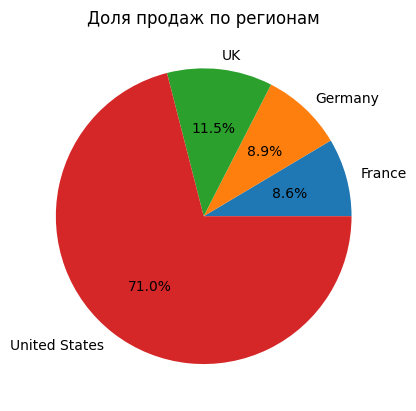

In [381]:
pie = df.groupby("region")["payer"].sum()
pie.plot.pie(autopct='%.1f%%')
plt.ylabel("")
plt.title("Доля продаж по регионам")
plt.show()

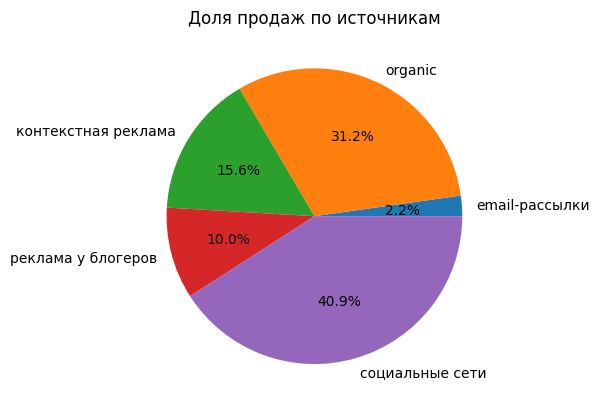

In [382]:
pie = df.groupby("channel")["payer"].sum()
pie.plot.pie(autopct='%.1f%%')
plt.ylabel("")
plt.title("Доля продаж по источникам")
plt.show()

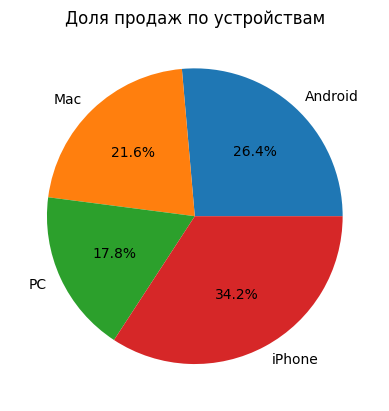

In [383]:
pie = df.groupby("device")["payer"].sum()
pie.plot.pie(autopct='%.1f%%')
plt.ylabel("")
plt.title("Доля продаж по устройствам")
plt.show()

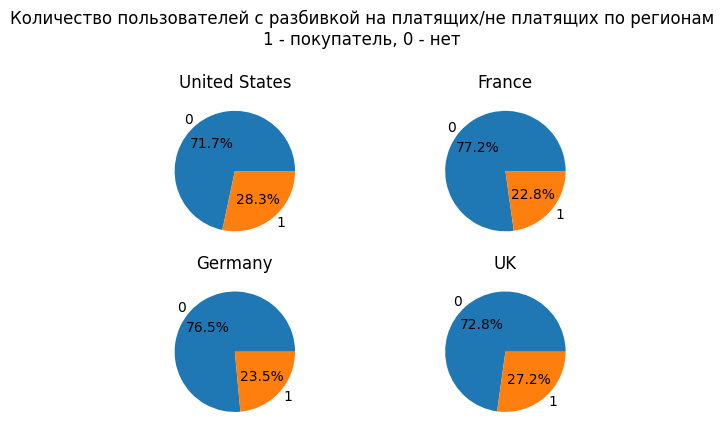

In [384]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(top=0.8)

labels = [0, 1]

ax_inds = [(0, 0), (0, 1), (1, 0), (1, 1)]
regions = df["region"].unique().tolist()

for i in range(len(regions)):
    region = regions[i]
    axs[ax_inds[i]].pie(df[df["region"] == region].groupby("payer")["payer"].count(),
                        labels=labels, autopct='%.1f%%')
    axs[ax_inds[i]].set_title(region)

plt.suptitle("Количество пользователей с разбивкой на платящих/не платящих по регионам\n1 - покупатель, 0 - нет")

plt.ylabel("")
plt.show()

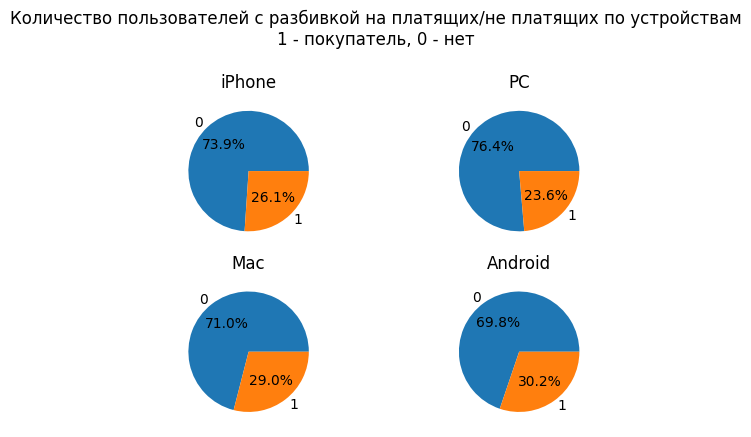

In [385]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(top=0.8)

labels = [0, 1]

ax_inds = [(0, 0), (0, 1), (1, 0), (1, 1)]
devices = df["device"].unique().tolist()

for i in range(len(devices)):
    device = devices[i]
    axs[ax_inds[i]].pie(df[df["device"] == device].groupby("payer")["payer"].count(),
                        labels=labels, autopct='%.1f%%')
    axs[ax_inds[i]].set_title(device)

plt.suptitle("Количество пользователей с разбивкой на платящих/не платящих по устройствам\n1 - покупатель, 0 - нет")

plt.ylabel("")
plt.show()

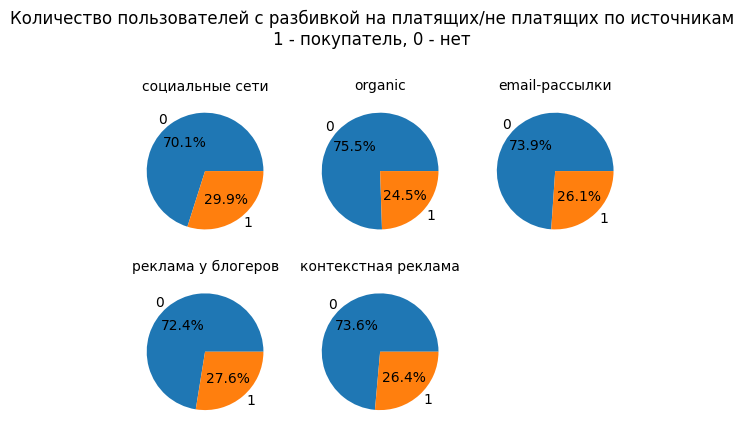

In [386]:
fig, axs = plt.subplots(2, 3)
fig.subplots_adjust(top=0.8)

labels = [0, 1]

ax_inds = [(0, 0), (0, 1), (1, 0), (1, 1), (0, 2)]
channels = df["channel"].unique().tolist()

for i in range(len(channels)):
    channel = channels[i]
    axs[ax_inds[i]].pie(df[df["channel"] == channel].groupby("payer")["payer"].count(),
                        labels=labels, autopct='%.1f%%')
    axs[ax_inds[i]].set_title(channel, fontsize=10)

axs[(1, 2)].axis('off')

plt.suptitle("Количество пользователей с разбивкой на платящих/не платящих по источникам\n1 - покупатель, 0 - нет")

plt.ylabel("")
plt.show()

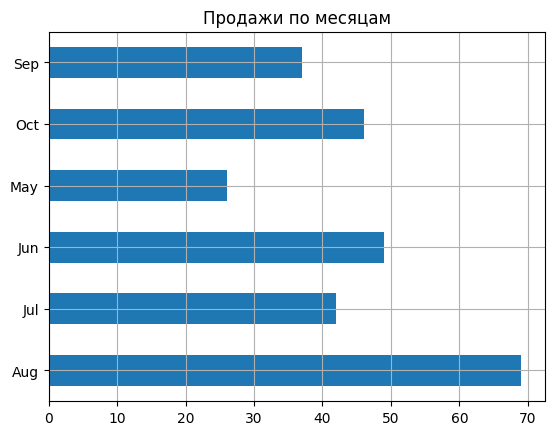

In [387]:
hist = df[df["payer"] == 1].value_counts("s_month", sort=False)
hist.plot.barh(grid=True)
plt.title("Продажи по месяцам")
plt.ylabel("")
plt.show()

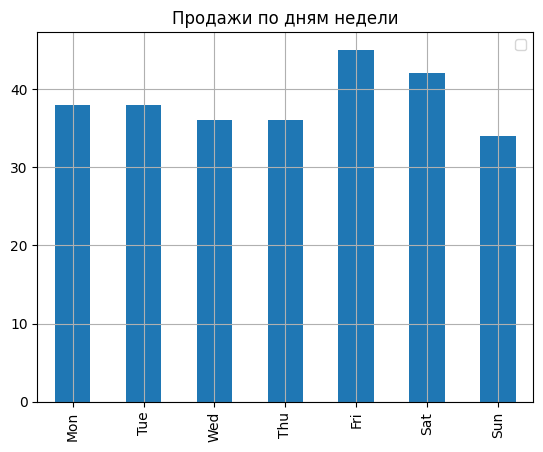

In [388]:
hist = df[df["payer"] == 1].value_counts("day", sort=False).reset_index()
hist.index = hist["day"].apply(lambda x: list(calendar.day_abbr)[x - 1])
hist = hist.drop(["day"], axis=1)
hist.plot.bar(grid=True)
plt.title("Продажи по дням недели")
plt.legend("")
plt.xlabel("")
plt.show()

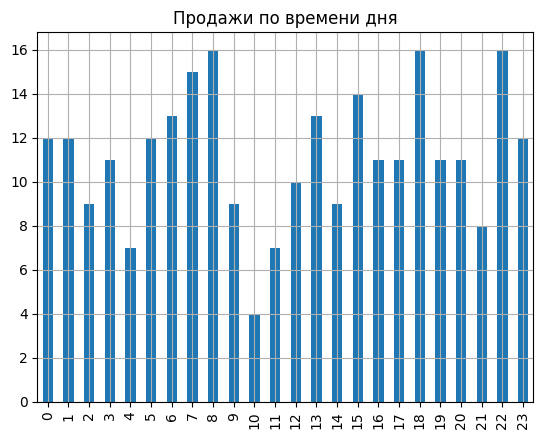

In [401]:
hist = df[df["payer"] == 1].value_counts("hour_of_day", sort=False)
hist.plot.bar(grid=True)
plt.title("Продажи по времени дня")
plt.xlabel("")
plt.show()

Ночью покупали больше всего? Это связано с тем, что основные покупатели из Америки, где в это время день, а у нас ночь.

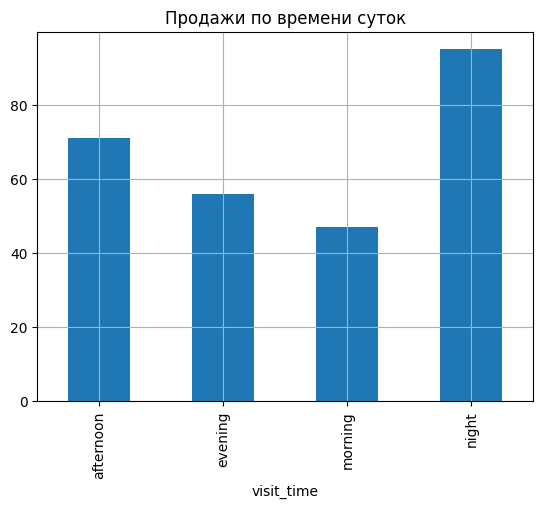

In [390]:
hist = df[df["payer"] == 1].value_counts("visit_time", sort=False)
hist.plot.bar(grid=True)
plt.title("Продажи по времени суток")
plt.show()

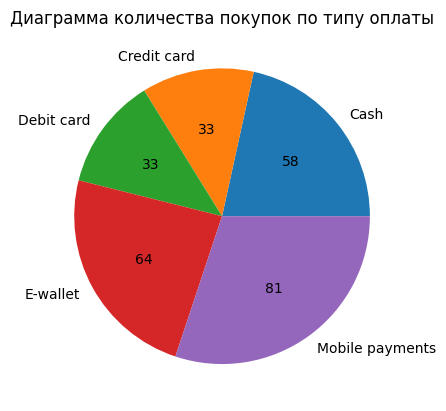

In [391]:
pie = df[df["payer"] == 1].groupby("payment_type").sum("payer")["payer"]
pie.plot.pie(autopct=lambda x: '{:.0f}'.format(x * pie.sum() / 100))
plt.ylabel("")
plt.title("Диаграмма количества покупок по типу оплаты")
plt.show()

Первая и вторая гипотеза через ANOVA

1. Влияет ли тип устройства на количество покупок в день по каждому региону?

2. Влияет ли тип рекламного канала на количество покупок в день по каждому региону?

H0: все средние значения совокупности равны
H1: по крайней мере одно среднее значение популяции отличается от остальных

In [403]:
regions = df['region'].unique()
for region in regions:
    region_data = df[(df['region'] == region) & (df["payer"] == 1)]
    reg = region_data.groupby("session_date")["payer"].count().reset_index(name="count")["count"]

    devices = region_data['device'].unique()

    devices_res = []

    for device in devices:
        dev = region_data[region_data["device"] == device].groupby("session_date")["payer"].count().reset_index(name="count")["count"]
        devices_res.append(dev)

    stats, pvalue = f_oneway(*devices_res)
    if pvalue >= 0.05:
        print("H0", region, stats, pvalue)
    else:
        print("H1", region, stats, pvalue)

regions = df['region'].unique()
for region in regions:
    region_data = df[(df['region'] == region) & (df["payer"] == 1)]
    reg = region_data.groupby("session_date")["payer"].count().reset_index(name="count")["count"]

    channels = region_data['channel'].unique()

    channels_res = []

    for channel in channels:
        dev = region_data[region_data["channel"] == channel].groupby("session_date")["payer"].count().reset_index(name="count")["count"]
        channels_res.append(dev)

    stats, pvalue = f_oneway(*channels_res)
    if pvalue >= 0.05:
        print("H0", region, stats, pvalue)
    else:
        print("H1", region, stats, pvalue)

H0 United States 1.063960071630043 0.36620709138862023
H1 France nan nan
H1 Germany nan nan
H0 UK 1.1074074074074076 0.36396392117603416
H0 United States 1.803404682291817 0.14966610966390423
H0 France 0.742063492063492 0.5415729350540206
H0 Germany 0.2980318650421743 0.8263461446417601
H0 UK 0.35632183908045983 0.7849822422282045


C:\Users\Roma\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\Roma\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


Гипотеза 3: Проверить гипотезу о том, что средний чек отличается в зависимости от региона?

In [394]:
df[df["payer"] == 1].groupby("region")["total_price"].mean()

region
France           5255.547826
Germany          5344.862500
UK               5540.954839
United States    5422.067539
Name: total_price, dtype: float64

Гипотеза 4: Проверить гипотезу о том, что средний чек отличается в зависимости от рекламного канала?

In [395]:
df[df["payer"] == 1].groupby("channel")["total_price"].mean()

channel
email-рассылки         5332.366667
organic                5432.365476
контекстная реклама    5122.847619
реклама у блогеров     5380.496296
социальные сети        5525.390000
Name: total_price, dtype: float64

Гипотеза 5: Проверить гипотезу о том, что средний чек отличается в зависимости от времени суток?

In [396]:
df[df["payer"] == 1].groupby("visit_time")["total_price"].mean()

visit_time
afternoon    5448.321127
evening      5479.400000
morning      5109.670213
night        5502.180000
Name: total_price, dtype: float64

Гипотеза 6: Есть ли взаимосвязь между продолжительностью сессии с суммой покупок?

In [397]:
df[df["payer"] == 1][["session_duration_sec", "total_price"]].corr("spearman")  # корреляции очень слабая

,session_duration_sec,total_price
session_duration_sec,1.000000,-0.023183
total_price,-0.023183,1.000000


Гипотеза 7: Влияет ли регион на тип оплаты продукта?

In [398]:
cont_table = pd.crosstab(df["region"], df["payment_type"])
chi2_contingency(cont_table).pvalue # данные между регионом и типом оплаты независимы (недостаточно данных)

0.9724674757265976

Гипотеза 8: Влияет ли день недели на кол-во покупок?

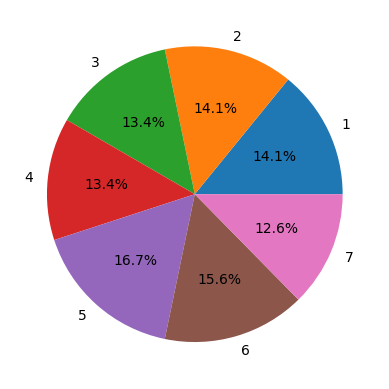

In [399]:
bh = df[df["payer"] == 1]
bh = bh.groupby("day")["payer"].count()
bh.plot.pie(autopct='%.1f%%')
plt.ylabel("")
plt.show() # Из диаграммы видно, что особых различий между кол-вом покупок нет. Вывод: день недели не зависит от покупок

Регрессионная модель факторов *region*, *channel* и отклика *payer*

In [400]:
a = ["region", "channel"]
X = df[a]
y = df[["payer"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

column_transformer = ColumnTransformer(
    [('encoder', OneHotEncoder(sparse_output=False), a)],
    remainder='passthrough'
)

X_train_encoded = column_transformer.fit_transform(X_train)
X_test_encoded = column_transformer.transform(X_test)

model = LinearRegression()
model.fit(X_train_encoded, y_train)

y_pred = model.predict(X_test_encoded)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"Среднеквадратичная ошибка модели: {mse}")
print(r2)

Среднеквадратичная ошибка модели: 0.21065655425565327
-0.04173454109367203
